## 2. Forecasting 

In [55]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.weightstats import DescrStatsW
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [56]:
# Read data and index it by date
data = pd.read_csv("data.csv")
indexed = data.set_index('date')
indexed.head()

,day.of.week,car.count,weather,cloud.indicator
date,,,,
2010-01-01,Friday,101,0.1,clear
2010-01-02,Saturday,34,0.2,cloudy
2010-01-03,Sunday,113,0.4,clear
2010-01-04,Monday,5,0.6,cloudy
2010-01-05,Tuesday,124,0.1,clear


### a. Model Construction
#### a1. EDA for Model Selection

Text(0.5,1,'First Order Lag Plot')

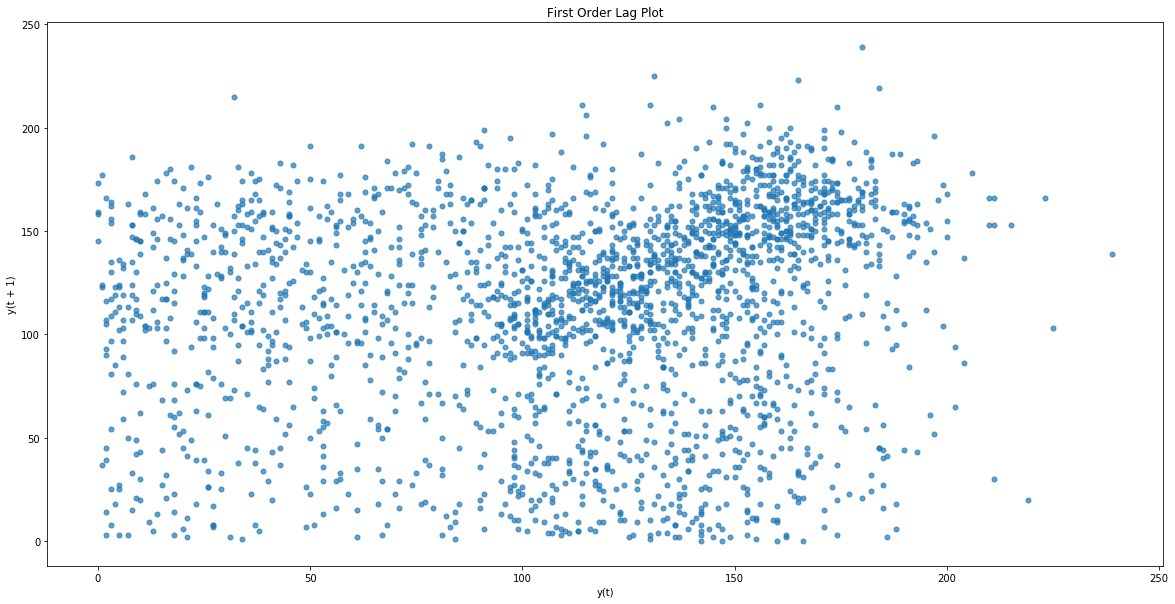

In [57]:
# Draw lag plot to check autocorrelation
from pandas.plotting import lag_plot
fig, ax = plt.subplots(figsize=(20,10))
lag_plot(indexed['car.count'], lag=1, alpha=0.7, s=25)
plt.title('First Order Lag Plot')

Conclusions from the lag plot     
- The data points seem to be random, however after 100th point to 200th point there seems some correlation as the plot looks dense with a specific slope but still the correlation is quite less
- The data exhibit no autocorrelation.
- The data contains some outliers.     

Lets see if the ACF and PACF plots show some correlation with lags -     
- the ACF plot does not show a lot of correlation as we see the values are pretty low.
- We see some odd spikes in PACF plot but that might be an exception.

In [58]:

# fig, axes = plt.subplots( 2, figsize=(20,10))
# _ = tsaplots.plot_acf(indexed['car.count'], axes[0], lags=1500, title='ACF till 1500 lags')
# _ = tsaplots.plot_pacf(indexed['car.count'], axes[1], lags=1500, title='PACF till 1500 lags')

For a clear picture lets limit the ACF and PACF plots to 150 lags   

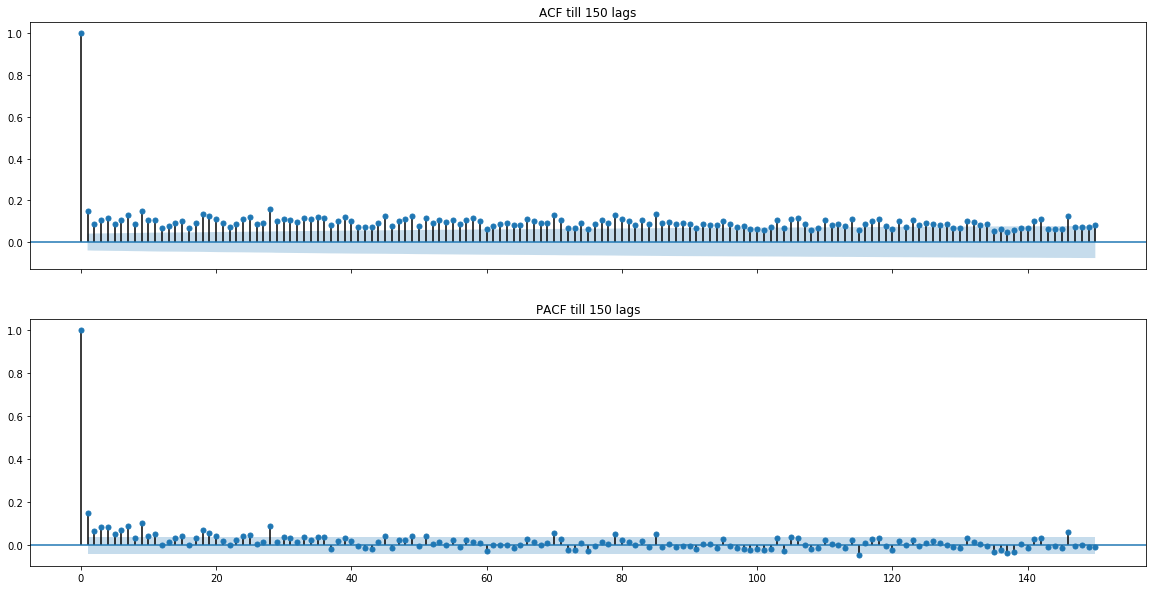

In [59]:
fig, axes = plt.subplots( 2, figsize=(20,10), sharex=True)
_ = tsaplots.plot_acf(indexed['car.count'], axes[0], lags=150, title='ACF till 150 lags')
_ = tsaplots.plot_pacf(indexed['car.count'], axes[1], lags=150, title='PACF till 150 lags')

The Blue shaded region is 95% Confidence intervals, suggesting that correlation(ACF) values outside of this are very likely a correlation and not a statistical fluke. we see in the ACF plot the correlation is very less from lag 1. 

Seeing the above plots I decided to use a non traditional way rather than the traditional approaches(like ARIMA, ARIMAX, SARIMAX, etc) to model time series because of the following points      
- The data seems to have very little correlation with the lag variables as per the first order lag plot, ACF and PACF plots.        
- Converting this time series problem into a regression problem by including the lag values of car count and weather can be a better solution than the traditional ones.     

####  Approach    
- Train an ARIMAX model with the exogenous data 
    - Convert Week day and Cloud indicator to numerical using one hot encoding and use weather data as it is.
    - Convert the timeseries to a stationary by diferencing(as from EDA we know that the time series does not look stationary) to find the parameter d of ARIMA
    - Find p,q parameters for ARMA model and learn the exog parameters by ARIMAX(use SARIMAX with seasonal_order is (0,0,0,0) as it becomes ARIMAX)
    - Do Residual analysis and find the MAE(Mean Absolute Error) for comparison
- Train Random Forest Regressor
    - get the features as mentioned above, also include lag values of car count and weather upto 5 lags.
    - Do Residual analysis and find the MAE(Mean Absolute Error) for comparison

In [60]:
indexed.head()

,day.of.week,car.count,weather,cloud.indicator
date,,,,
2010-01-01,Friday,101,0.1,clear
2010-01-02,Saturday,34,0.2,cloudy
2010-01-03,Sunday,113,0.4,clear
2010-01-04,Monday,5,0.6,cloudy
2010-01-05,Tuesday,124,0.1,clear


In [61]:
def getOneHotEncodingDF(df,column):
    """Function to get one hot encoding DF
    Args:
        df: Dataframe of Source data
        column: column in dataframe to be converted
    Returns: 
        Dataframe of Dummy variables
    """
    return pd.get_dummies(df[column])

def getLagsDF(df, column, lags=1):
    """Function to get Dataframe of lags value 
    Args:
        df: Dataframe of Source data
        column: column in dataframe for which lag values required
        lags: number of lags value to be returned in DF
            default - 1 
    Returns: 
        Dataframe of lag values of real valued columns
    """
    lagsDF = pd.DataFrame() 
    for i in range(1, lags+1):
        lagsDF[column+'(t-'+str(i)+')'] = df[column].shift(i)
    return lagsDF

def getADFullerTestResults(data):
    """Function to get Augmented DickeyFuller test results 
    Args:
        df: Series of data to be tested
    Returns: 
        Dataframe of test results
    """
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic',
                                'p-value',
                                '#Lags Used',
                                'Number of Observations Used'])

    for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [62]:
# One hot encoding categorical variables
daysEncodedDF = getOneHotEncodingDF(indexed, 'day.of.week')
cloudEncodedDF = getOneHotEncodingDF(indexed, 'cloud.indicator')
cloudEncodedDF = cloudEncodedDF.drop(['cloudy'], axis=1)

# get Lag values of time dependent variables
carCountLagsDF = getLagsDF(indexed, 'car.count', 5)
weatherLagsDF = getLagsDF(indexed, 'weather', 5)
cloudLagDF = getLagsDF(indexed, 'cloud.indicator', 5)

# Concatenate all the data frames and remove nan values
df = pd.concat([daysEncodedDF, cloudEncodedDF, carCountLagsDF, weatherLagsDF], axis=1)
df['weather'] = indexed['weather']
df['target'] = indexed['car.count']
df = df.dropna()

df.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,clear,car.count(t-1),car.count(t-2),car.count(t-3),car.count(t-4),car.count(t-5),weather(t-1),weather(t-2),weather(t-3),weather(t-4),weather(t-5),weather,target
date,,,,,,,,,,,,,,,,,,,,
2010-01-06,0,0,0,0,0,0,1,1,124.0,5.0,113.0,34.0,101.0,0.1,0.6,0.4,0.2,0.1,-0.1,104
2010-01-07,0,0,0,0,1,0,0,1,104.0,124.0,5.0,113.0,34.0,-0.1,0.1,0.6,0.4,0.2,-1.0,81
2010-01-08,1,0,0,0,0,0,0,0,81.0,104.0,124.0,5.0,113.0,-1.0,-0.1,0.1,0.6,0.4,-0.3,67
2010-01-09,0,0,1,0,0,0,0,0,67.0,81.0,104.0,124.0,5.0,-0.3,-1.0,-0.1,0.1,0.6,0.2,89
2010-01-10,0,0,0,1,0,0,0,1,89.0,67.0,81.0,104.0,124.0,0.2,-0.3,-1.0,-0.1,0.1,1.4,132


In [63]:
# Split train and test data based on date
trainDF = df.loc[:'2016-03-31']
testDF = df.loc['2016-04-01':]

X = trainDF.drop('target', axis=1).sample(frac=1).values
Y = trainDF['target'].values

XTest = testDF.drop('target', axis=1).values
YTest = testDF['target'].values

##### ARIMAX Model

In [64]:
# Prepare exogenous data for ARIMAX
exog = pd.concat([daysEncodedDF, cloudEncodedDF], axis=1)
exog['weather'] = indexed['weather']
exog = exog.dropna()

# Split train and test data based on date
trainExog = exog.loc[:'2016-03-31']
testExog = exog.loc['2016-04-01':]
YarimaxTrain = indexed.loc[:'2016-03-31']['car.count']
YarimaxTest = indexed.loc['2016-04-01':]['car.count']

Text(0.5,1,'Differenced values')

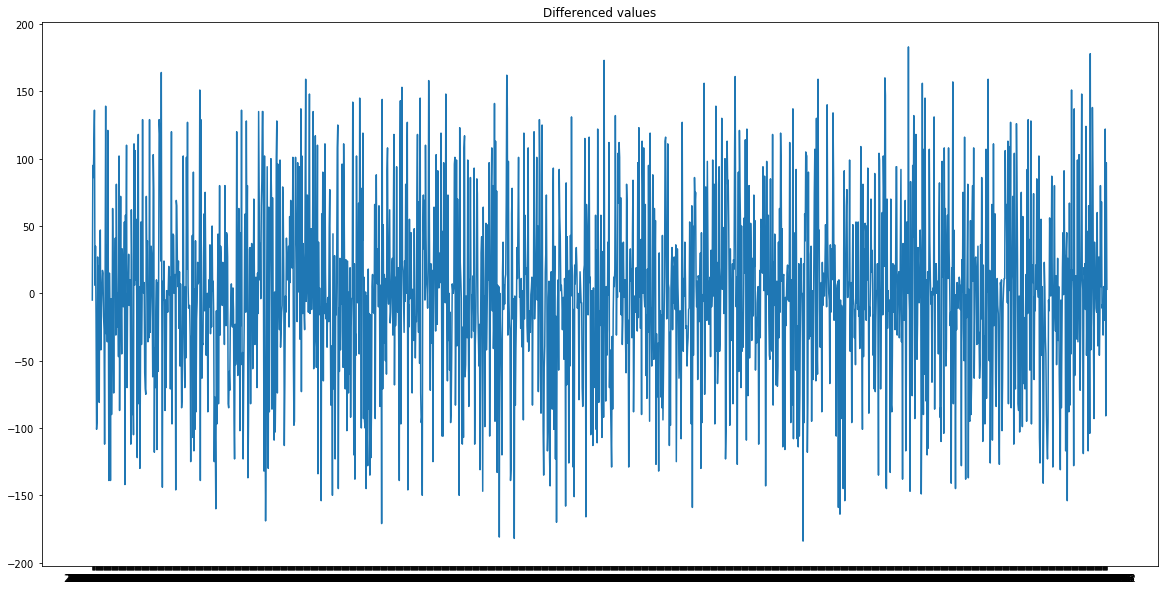

In [65]:
# finding d parameter of ARIMA to see if the series becomes stationary
differenced= indexed['car.count'] - indexed['car.count'].shift(1)
fig, ax = plt.subplots(figsize=(20,10))
#plot sample
plt.plot(differenced.sample(frac=0.8))
plt.title('Differenced values')

The first order difference now looks stationary with mean close to 0 and almost equal variance with time with some minor outliers. Lets confirm it with Augmented Dickey Fuller test. if the pvalue is less than significance value than we can say that the series is stationary.

In [66]:
differenced = differenced.dropna()
print('Results of Augmented Dickey Fuller Test for first order Differenced Values')
getADFullerTestResults(differenced)

Results of Augmented Dickey Fuller Test for first order Differenced Values


Test Statistic                -1.684598e+01
p-value                        1.128409e-29
#Lags Used                     2.600000e+01
Number of Observations Used    2.345000e+03
Critical Value (1%)           -3.433142e+00
Critical Value (5%)           -2.862773e+00
Critical Value (10%)          -2.567427e+00
dtype: float64

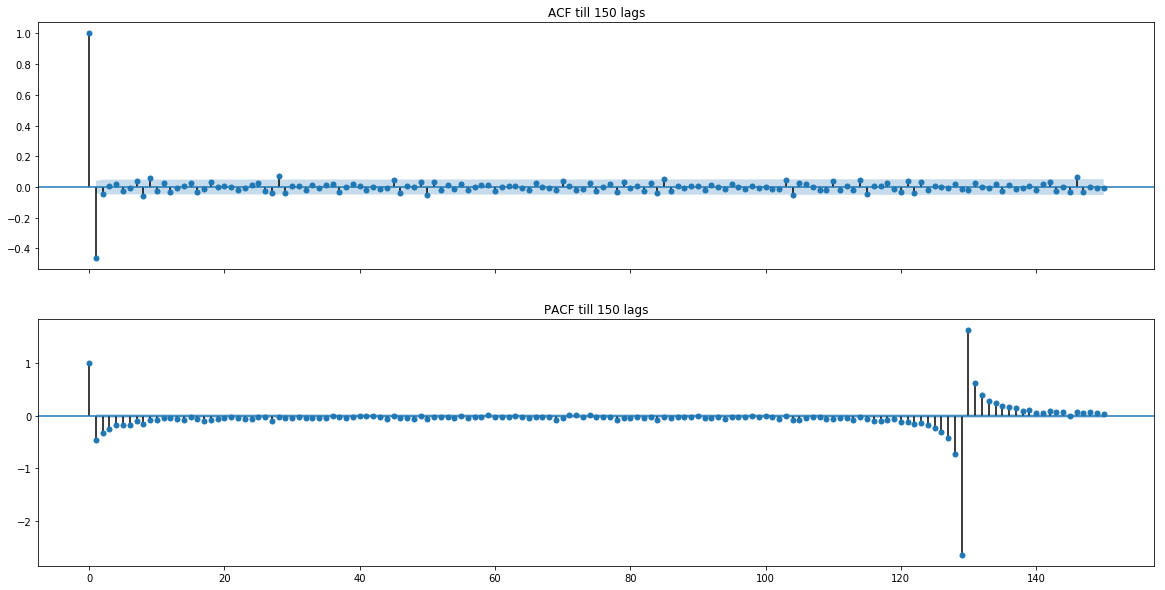

In [67]:
fig, axes = plt.subplots( 2, figsize=(20,10), sharex=True)
_ = tsaplots.plot_acf(differenced, axes[0], lags=150, title='ACF till 150 lags')
_ = tsaplots.plot_pacf(differenced, axes[1], lags=150, title='PACF till 150 lags')

In [68]:
# Finding best p and q parameters using minimum AIC score for ARMA model
resDiff = sm.tsa.arma_order_select_ic(differenced, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (6, 6) is the best.


In [69]:
arimax = sm.tsa.statespace.SARIMAX(YarimaxTrain,order=(6,1,6),seasonal_order=(0,0,0,0),exog = trainExog,
                                   freq='D', enforce_stationarity=False, enforce_invertibility=False).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              car.count   No. Observations:                 2282
Model:               SARIMAX(6, 1, 6)   Log Likelihood              -11050.425
Date:                Thu, 18 Jul 2019   AIC                          22144.849
Time:                        08:37:19   BIC                          22270.894
Sample:                    01-01-2010   HQIC                         22190.830
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Friday        -1.5340      1.728     -0.888      0.375      -4.922       1.854
Monday         0.2590      1.708      0.152      0.879      -3.089       3.607
Saturday       4.7019      1.651      2.848      0.004       1.466       7.938
Sunday         1.9170      1.731      1.107      0.268      -1.477       5.311
Thursday      -2.4765      1.628     -1.521      0.128      -5.667       0.714
Tuesday       -0.7767      1.627     -0.477      0.633      -3.965       2.411
Wednesday     -2.0908      1.649     -1.268      0.205      -5.323       1.141
clear         73.8515      1.237     59.716      0.000      71.428      76.275
weather       -1.0115      0.684     -1.479      0.139      -2.352       0.329
ar.L1         -1.1088      0.222     -4.986      0.000      -1.545      -0.673
ar.L2         -0.4947      0.202     -2.452      0.014      -0.890      -0.099
ar.L3         -0.7474      0.065    -11.496      0.000      -0.875      -0.620
ar.L4         -1.1355      0.202     -5.618      0.000      -1.532      -0.739
ar.L5         -0.7299      0.217     -3.371      0.001      -1.154      -0.306
ar.L6         -0.0118      0.026     -0.458      0.647      -0.062       0.039
ma.L1          0.1561      0.223      0.701      0.483      -0.280       0.593
ma.L2         -0.5977      0.183     -3.267      0.001      -0.956      -0.239
ma.L3          0.2718      0.250      1.085      0.278      -0.219       0.763
ma.L4          0.4397      0.247      1.780      0.075      -0.044       0.924
ma.L5         -0.3987      0.182     -2.194      0.028      -0.755      -0.043
ma.L6         -0.7316      0.223     -3.281      0.001      -1.169      -0.295
sigma2       989.7023     27.663     35.777      0.000     935.484    1043.921
===================================================================================
Ljung-Box (Q):                       30.07   Jarque-Bera (JB):                45.15
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+17. Standard errors may be unstable.
"""

Text(0,0.5,'Density')

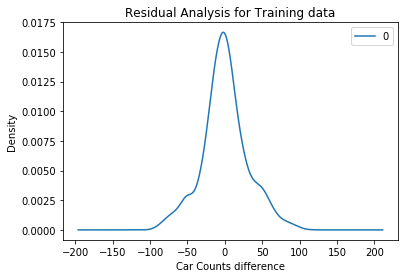

In [70]:
residuals = pd.DataFrame(arimax.resid)
residuals.plot(kind='kde')
plt.title('Residual Analysis for Training data')
plt.xlabel('Car Counts difference')
plt.ylabel('Density')

Text(0,0.5,'Car Counts')

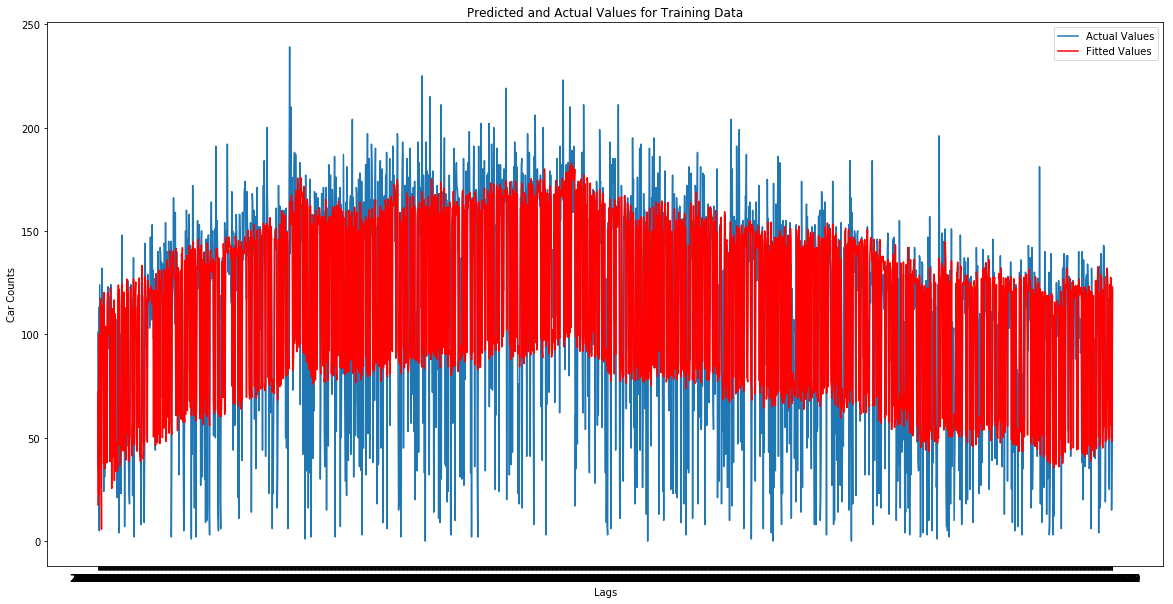

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(YarimaxTrain, label='Actual Values')
plt.plot(arimax.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best')
plt.title('Predicted and Actual Values for Training Data')
plt.xlabel('Lags')
plt.ylabel('Car Counts')

In [72]:
print('Mean Absolute Error on Train Data for ARIMAX: '+str(mean_absolute_error(YarimaxTrain, arimax.fittedvalues)))

Mean Absolute Error on Train Data for ARIMAX: 23.177605710684446


In [49]:
# Getting feature Importance which can be later used for varaible selection
model = RandomForestRegressor(n_estimators=500, random_state=7, max_depth=50, min_samples_split=3)

model.fit(X, Y)
print(model.feature_importances_)

[0.0075224  0.00717493 0.00734299 0.00698755 0.00953866 0.00747601
 0.00831592 0.01109244 0.09296664 0.0941073  0.08466275 0.08980704
 0.09632395 0.07868257 0.0796897  0.07763161 0.0797236  0.07820736
 0.08274657]


In [50]:
# Corresponding columns for feature importance
trainDF.columns[0:-1]

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'clear', 'car.count(t-1)', 'car.count(t-2)',
       'car.count(t-3)', 'car.count(t-4)', 'car.count(t-5)', 'weather(t-1)',
       'weather(t-2)', 'weather(t-3)', 'weather(t-4)', 'weather(t-5)',
       'weather'],
      dtype='object')

In [51]:
# ToDo: plot feature importance

Text(0,0.5,'Car Counts')

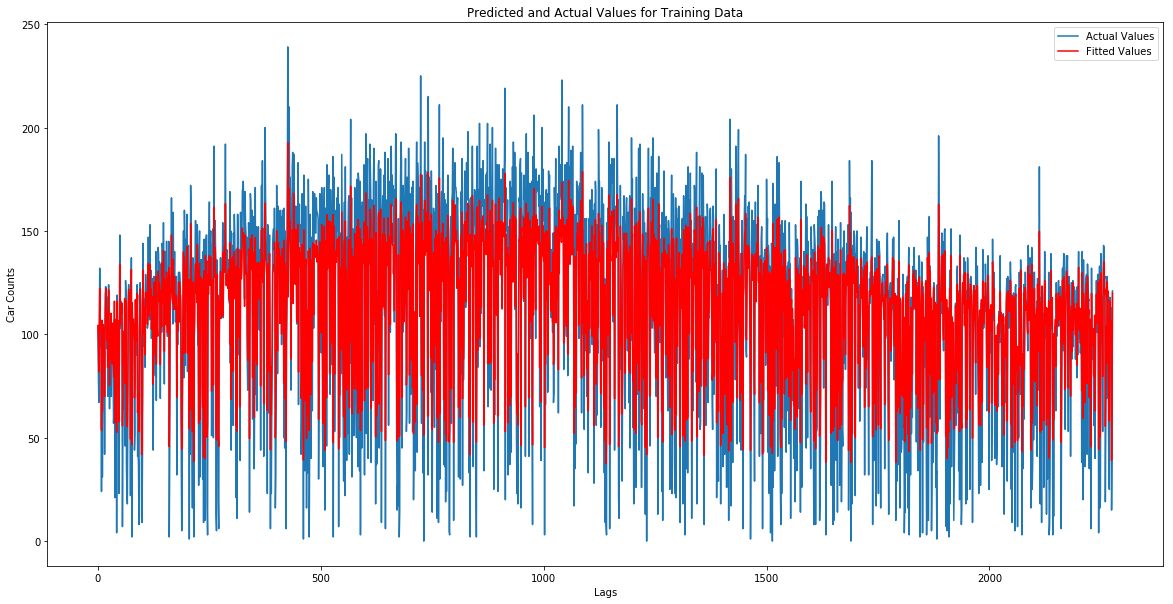

In [52]:
yHat = model.predict(X)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(Y, label='Actual Values')
plt.plot(yHat, color='red', label='Fitted Values')
plt.legend(loc='best')
plt.title('Predicted and Actual Values for Training Data')
plt.xlabel('Lags')
plt.ylabel('Car Counts')

In [53]:
print('Mean Absolute Error on Train Data for RF regressor: '+str(mean_absolute_error(Y, yHat)))

Mean Absolute Error on Train Data for RF regressor: 15.999192210770737


Answers to question a:     
- Predicting for one day in advance is shown in section d where we predict one day advance from the training data with its uncertainty.
- Parameters of the models:      
    - We binarize Cloud indicator(1 indicating clear) and use one hot encoding for day of week.
    - The numerical feature weather is used as it is as it is a zero mean normalized feature.
    - No other feature engineering was done due to lack of time many other features could have been included using external datasets.
    - The feature importance in RF regressor and coeff in the ARIMAX model can be used to find the importance of the variables, there are some which have lower importance like weather but I did not try various combinations of the predictors due to lack of time.
- To guard against overfiting various techniques can be used(but I haven't used due to shortage of time) like:
    - Time Series Cross validation
    - Using holdout Test and Validation to check the scores(Done in case of RF regressor)
    - using Occams Razor principal to use the simpler model(use lower order ARIMA by carfully considering AIC) 
- I binarized cloudy data 1 indicating clear and 0 indicating cloudy

### b. Residuals of best fit model

Text(0,0.5,'Density')

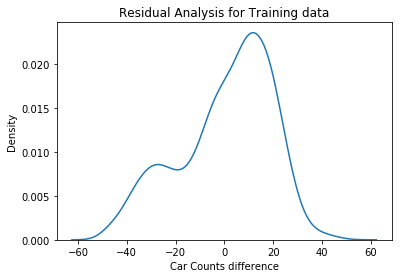

In [25]:
yHat = model.predict(X)
residualsRF = Y-yHat
sns.distplot(residualsRF, hist=False)
plt.title('Residual Analysis for Training data')
plt.xlabel('Car Counts difference')
plt.ylabel('Density')

In [26]:
print('Results of Augmented Dickey Fuller Test for Residuals of Training Data')
getADFullerTestResults(residualsRF)

Results of Augmented Dickey Fuller Test for Residuals of Training Data


Test Statistic                   -4.347996
p-value                           0.000366
#Lags Used                       27.000000
Number of Observations Used    2249.000000
Critical Value (1%)              -3.433261
Critical Value (5%)              -2.862826
Critical Value (10%)             -2.567455
dtype: float64

if p value is less than the significance level 0.05, so we can reject the Null Hypothesis hence we can reject that there is a unit root, which means the series is stationary     
if the test statistic is more than 5% critical value, this will show that time series is not stationary      
All the results show that the residuals are stationary      

Also the residuals have zero mean indicating no bias in the model.

### c. Validate/Test out of Sample performance      

I have kept a part of data from training as we have a hold out test sample where we can validate our model performance and make sure not overfitting the whole data.      
we see that the MAE of test data is greater than that of training data indicating underfitting or overfitting(somewhat over fitting in this case) will need to tune the model for proper generalization.

Text(0,0.5,'Car Counts')

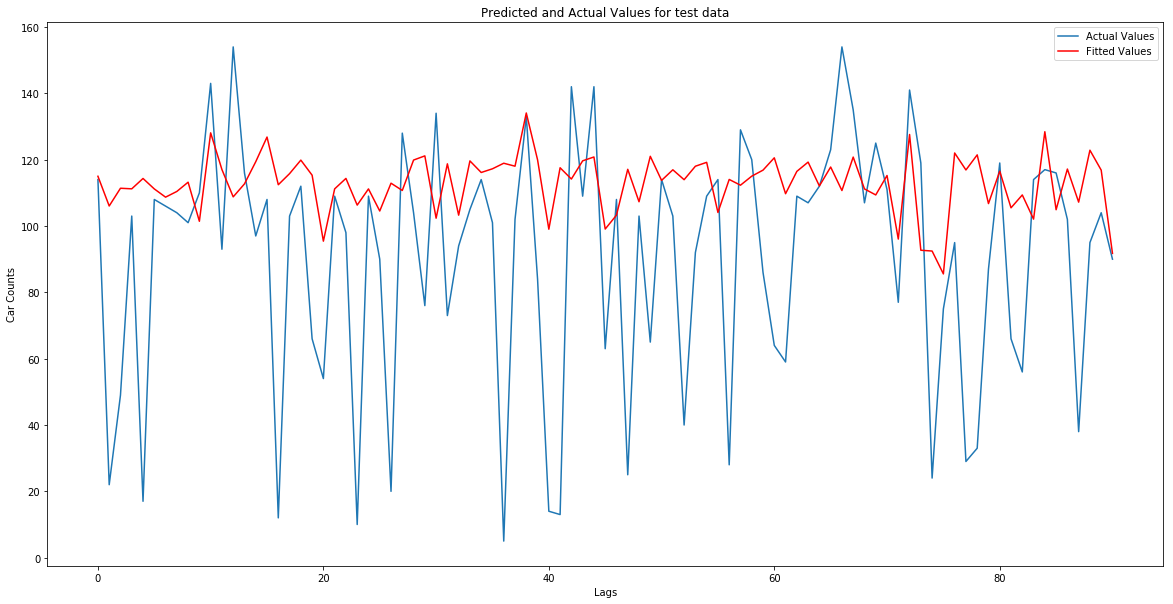

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
yHatTest = model.predict(XTest)
plt.plot(YTest, label='Actual Values')
plt.plot(yHatTest, color='red', label='Fitted Values')
plt.legend(loc='best')
plt.title('Predicted and Actual Values for test data')
plt.xlabel('Lags')
plt.ylabel('Car Counts')

In [28]:
print('Mean Absolute Error on Test Data for RF regressor: '+str(mean_absolute_error(YTest, yHatTest)))

Mean Absolute Error on Test Data for RF regressor: 30.359926739926742


### d. generate an uncertainty on our forecasted values

We have trained our Model till 2016-03-31 now lets try to predict car count value for 2016-04-01 with uncertainty.       
We can find the uncertainty by finding the 95% Confidence Interval of the prediction of multiple regressors in the RF regressor. 

In [29]:
data = np.array(testDF.drop('target', axis=1).loc['2016-04-01'].values).reshape(1, -1)

In [30]:
model.predict(data)[0]

127.02

In [31]:
def getConfInt(data, alpha = 0.05):
    preds = []
    for pred in model.estimators_:
        preds.append(pred.predict(data)[0])
    # Reference: http://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.tconfint_mean.html
    return DescrStatsW(preds).tconfint_mean(alpha=alpha, alternative='two-sided')

In [32]:
getConfInt(data)


(124.88533426183558, 129.15466573816443)

In [33]:
indexed.loc['2016-04-01']

day.of.week        Friday
car.count             114
weather               1.3
cloud.indicator     clear
Name: 2016-04-01, dtype: object

Here the actual value is 114 but the model has predicted 127 with 95% CI bounds as 124.9 to 129.2